# Segunda práctica de Aprendizaje Automático

Implementación del grupo 17, formado por:
- Sergio Barragán Blanco (100472343)
- Eduardo Alarcón Navarro (100472175)

# Lectura del fichero CSV


In [2]:
import pandas as pd
import numpy as np
# Load the data
data = pd.read_csv('Stars2.csv')

print(data)

     Temperature              L          R    A_M  Color Spectral_Class
0           3068       0.002400     0.1700  16.12    Red              M
1           3042       0.000500     0.1542  16.60    Red              M
2           2600       0.000300     0.1020  18.70    Red              M
3           2800       0.000200     0.1600  16.65    Red              M
4           1939       0.000138     0.1030  20.06    Red              M
..           ...            ...        ...    ...    ...            ...
235        38940  374830.000000  1356.0000  -9.93   Blue              O
236        30839  834042.000000  1194.0000 -10.63   Blue              O
237         8829  537493.000000  1423.0000 -10.73  White              A
238         9235  404940.000000  1112.0000 -11.23  White              A
239        37882  294903.000000  1783.0000  -7.80   Blue              O

[240 rows x 6 columns]


# A continuación, haremos nuestra propia implementación del Kmeans

In [ ]:

class Kmeans():
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = 343175
        self.cluster_centers_ = None

    def fit(self, X, y=None, sample_weight=None):
        # Inicialización de los centroides de manera aleatoria
        rng = np.random.default_rng(self.random_state)
        self.cluster_centers_ = rng.choice(X, size=self.n_clusters, replace=False)

        for _ in range(self.max_iter):
            # Asignación de puntos a los centroides más cercanos
            labels = self._assign_labels(X)

            # Actualización de los centroides
            new_centers = self._compute_centers(X, labels)

            # Verificar si los centroides han convergido
            if np.allclose(self.cluster_centers_, new_centers, atol=self.tol):
                break
            
            self.cluster_centers_ = new_centers

    def _assign_labels(self, X):
        labels = np.empty(X.shape[0], dtype=int)
        for i, x in enumerate(X):
            # Calcular la distancia euclidiana a cada centroide
            distances = np.linalg.norm(self.cluster_centers_ - x, axis=1)
            # Asignar el punto al clúster con la distancia más corta
            labels[i] = np.argmin(distances)
        return labels

    def _compute_centers(self, X, labels):
        new_centers = np.empty_like(self.cluster_centers_)
        for i in range(self.n_clusters):
            # Calcular el nuevo centroide como el promedio de los puntos asignados al clúster i
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centers[i] = np.mean(cluster_points, axis=0)
            else:
                # Si no hay puntos asignados al clúster, mantener el centroide actual
                new_centers[i] = self.cluster_centers_[i]
        return new_centers


# A continuación, haremos el encoding de los datos, podemos hacer tanto OneHot como Ordinal

In [13]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,  OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
"""
Debido a que se usan distintos nombres para definir un mismo color, trataremos de unificarlos
"""

# Unificando los valores de los colores
mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
normalized_colors = list(mapping.keys())

# Mapeamos los datos
for target_color, source_colors in mapping.items():
  data.loc[data.Color.isin(source_colors), 'Color'] = target_color
"""
oe = OrdinalEncoder(categories=[normalized_colors])
data_encoded = oe.fit_transform(data.Color.values.reshape(-1, 1))

np.hstack([data.Color.values.reshape(-1, 1), data_encoded])
data
"""
ct = ColumnTransformer([
    ('OrdinalEncoding_Color', OrdinalEncoder(categories=[normalized_colors]), ["Color"]),
    ('OrdinalEncoding_Spectral', OrdinalEncoder(categories=[['O', 'B', 'A', 'F', 'G', 'K', 'M']]), ["Spectral_Class"])
], remainder="passthrough")


# Creamos el Pipeline con ColumnTransformer y KMeans
pipe = Pipeline([
    ("ColumnTransformer", ct),
    ("Scaler", StandardScaler()),
    ("PCA", PCA(n_components=2)),
    ("KMeans", KMeans(n_clusters=5, random_state=343175)),
])

# Ajustamos el pipeline con los datos
pipe.fit(data)

# Obtenemos los centroides de los clústeres
centroids = pipe.named_steps['KMeans'].cluster_centers_



Ahora lo mostraremos en una tabla

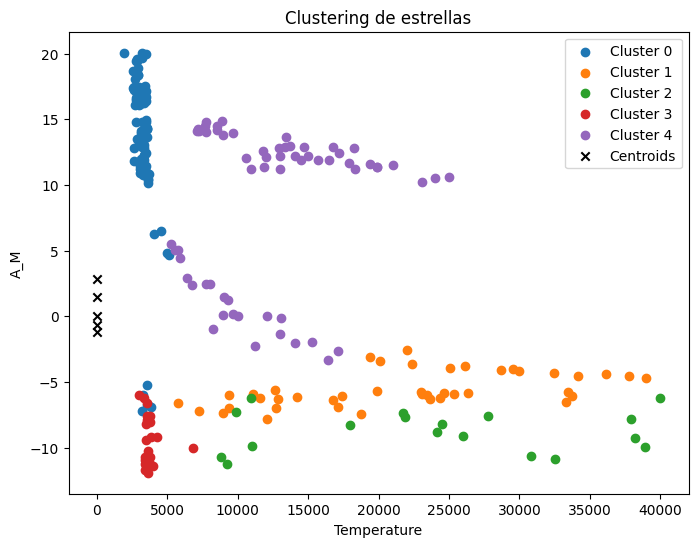

In [14]:
import matplotlib.pyplot as plt

# Obtén las etiquetas de los clústeres para cada muestra
labels = pipe.named_steps['KMeans'].labels_

# Crea un gráfico de dispersión
plt.figure(figsize=(8, 6))
for cluster_label in range(len(centroids)):
    # Selecciona las muestras que pertenecen a un clúster específico
    cluster_data = data[labels == cluster_label]
    # Grafica las muestras del clúster
    plt.scatter(cluster_data['Temperature'], cluster_data['A_M'], label=f'Cluster {cluster_label}')
# Grafica los centroides de los clústeres
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='black', label='Centroids')
plt.xlabel('Temperature')
plt.ylabel('A_M')
plt.title('Clustering de estrellas')
plt.legend()
plt.show()
